In [1]:
!pip install xgboost
!pip install imbalanced-learn
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.8 MB/s eta 0:00:00


In [2]:
# Import library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import category_encoders as ce
from imblearn.over_sampling import SMOTE, SVMSMOTE

In [44]:
df=pd.read_csv("/content/churn-bigml-80.csv")

In [5]:
df.isnull().sum()

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

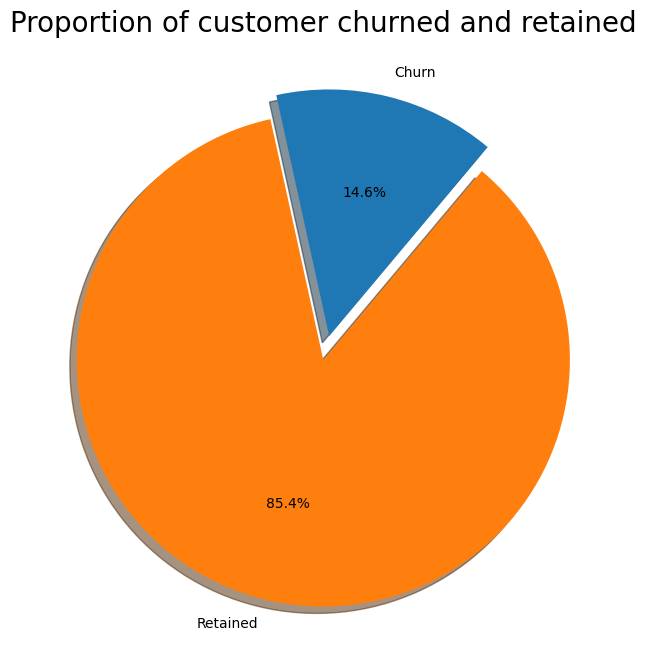

In [6]:
labels = 'Churn', 'Retained'
sizes = [df.Churn[df['Churn'] == 1].count(), df.Churn[df['Churn'] == 0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(7, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=50)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size=20)
plt.show()


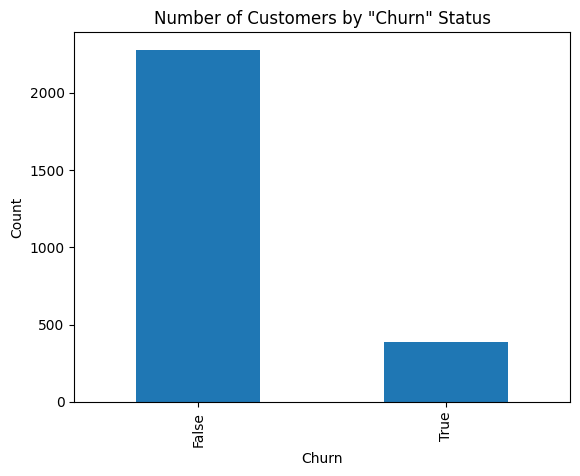

In [7]:
churn_counts = df['Churn'].value_counts()
churn_counts.plot(kind='bar')
plt.title('Number of Customers by "Churn" Status')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()


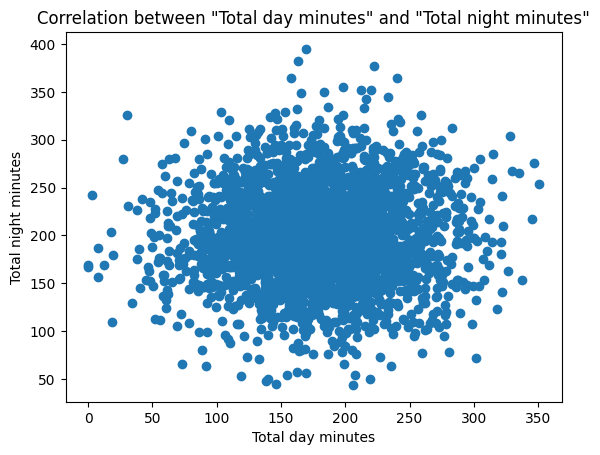

In [8]:

plt.scatter(df['Total day minutes'], df['Total night minutes'])
plt.title('Correlation between "Total day minutes" and "Total night minutes"')
plt.xlabel('Total day minutes')
plt.ylabel('Total night minutes')
plt.show()


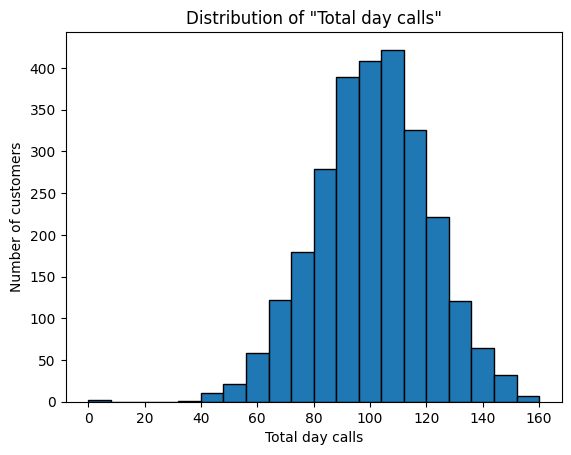

In [9]:
import matplotlib.pyplot as plt
plt.hist(df['Total day calls'], bins=20, edgecolor='k')
plt.title('Distribution of "Total day calls"')
plt.xlabel('Total day calls')
plt.ylabel('Number of customers')
plt.show()


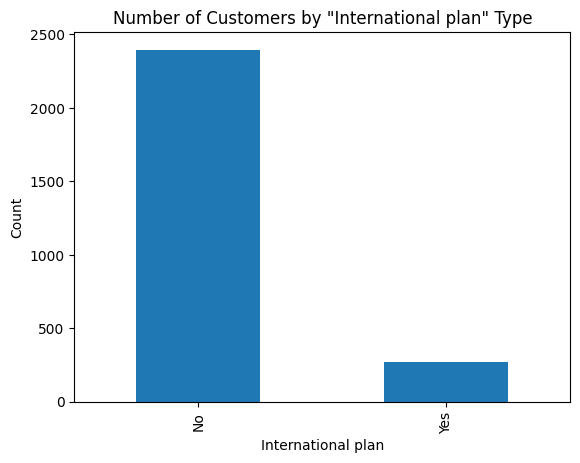

In [10]:
intl_plan_counts = df['International plan'].value_counts()
intl_plan_counts.plot(kind='bar')
plt.title('Number of Customers by "International plan" Type')
plt.xlabel('International plan')
plt.ylabel('Count')
plt.show()


In [11]:
data_types = df.dtypes
print(data_types)



State                      object
Account length              int64
Area code                   int64
International plan         object
Voice mail plan            object
Number vmail messages       int64
Total day minutes         float64
Total day calls             int64
Total day charge          float64
Total eve minutes         float64
Total eve calls             int64
Total eve charge          float64
Total night minutes       float64
Total night calls           int64
Total night charge        float64
Total intl minutes        float64
Total intl calls            int64
Total intl charge         float64
Customer service calls      int64
Churn                        bool
dtype: object


In [12]:
df['Churn'] = df['Churn'].astype('object')

In [13]:
object_cols = [f for f in df.columns if df[f].dtype == "O"]
print(object_cols)

['State', 'International plan', 'Voice mail plan', 'Churn']


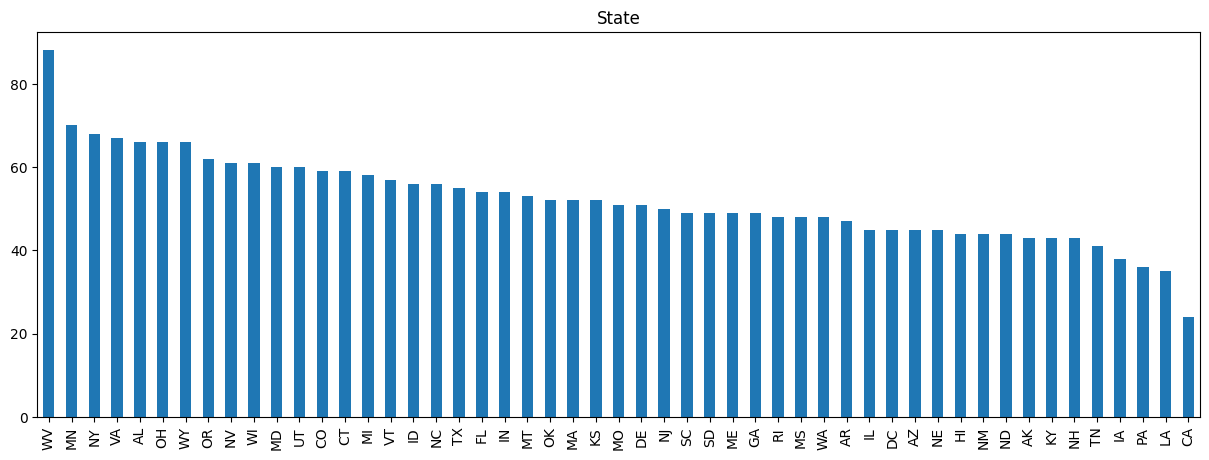

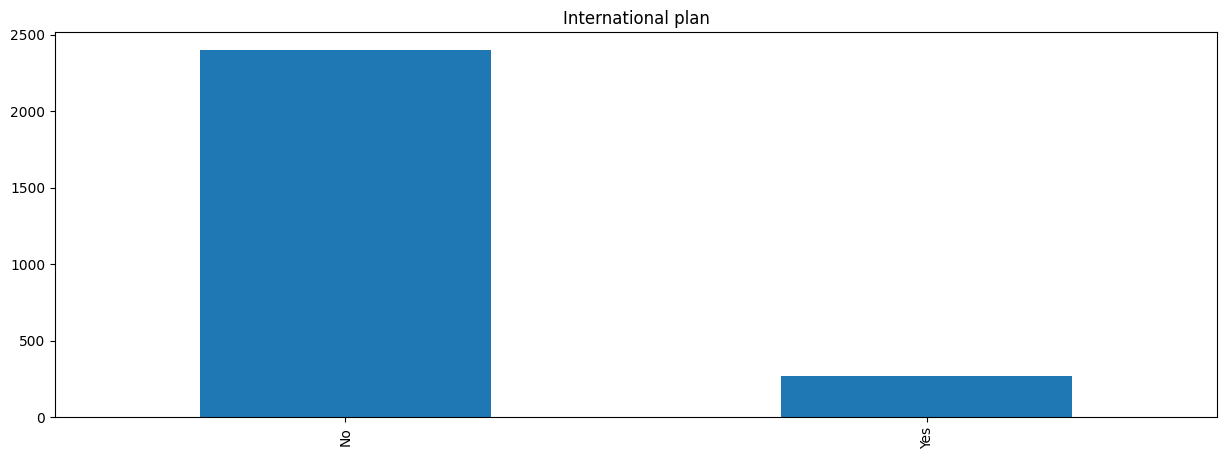

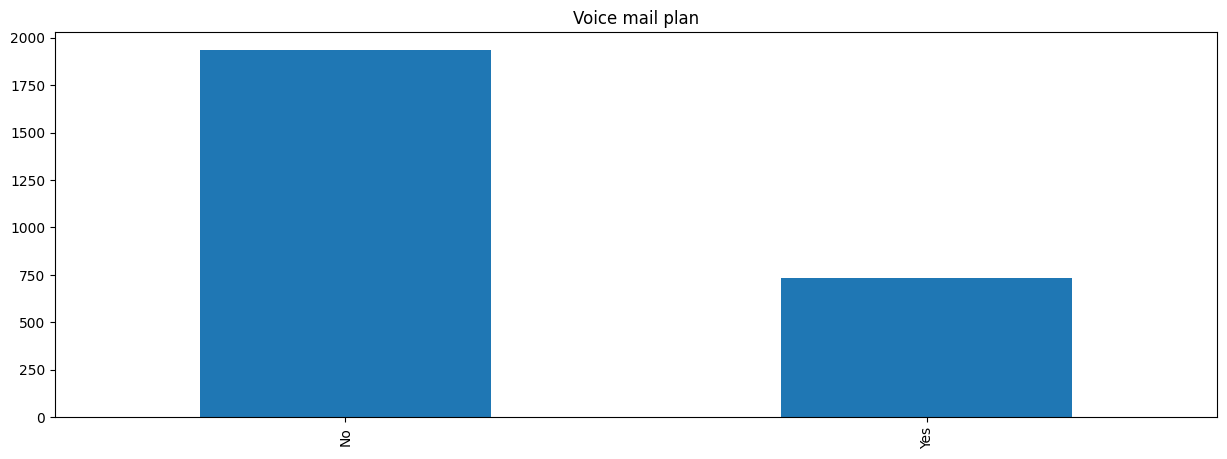

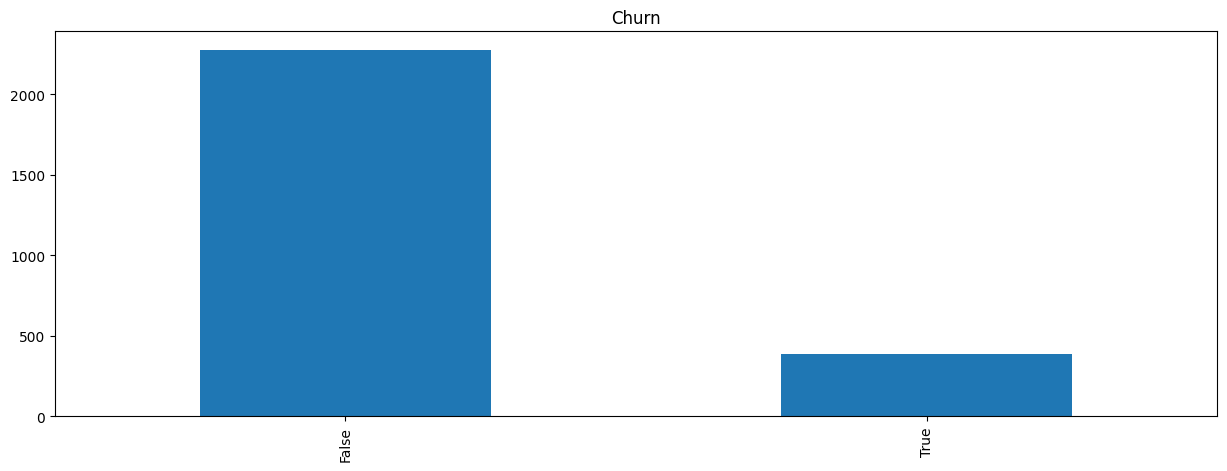

In [14]:
for col in object_cols:
  df[col].value_counts().plot(kind='bar', figsize=(15,5))
  plt.title(col)
  plt.show()

In [15]:
numeric_cols = [f for f in df.columns if df[f].dtype != "O"]
print(numeric_cols)

['Account length', 'Area code', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']


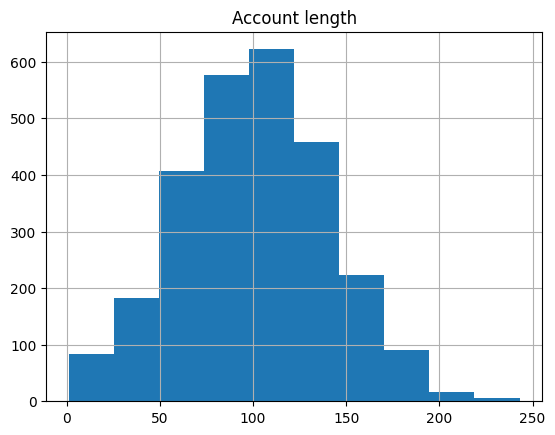

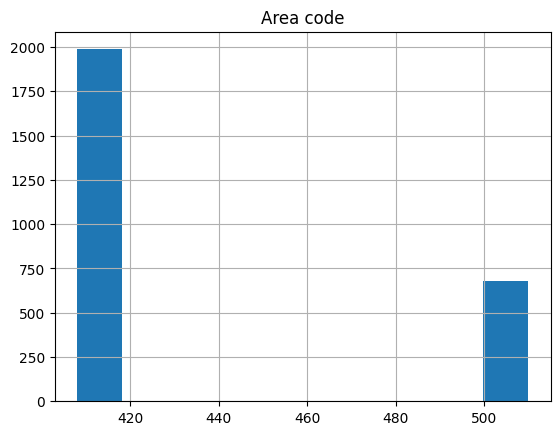

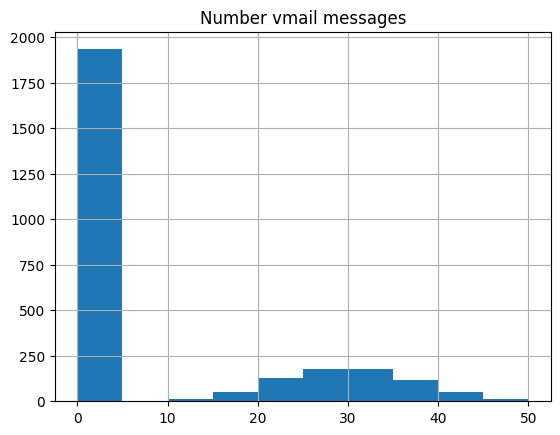

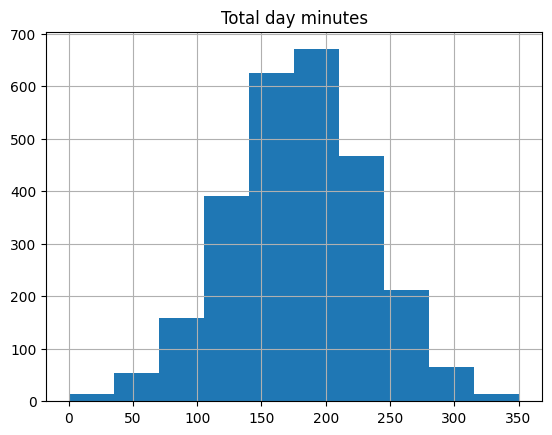

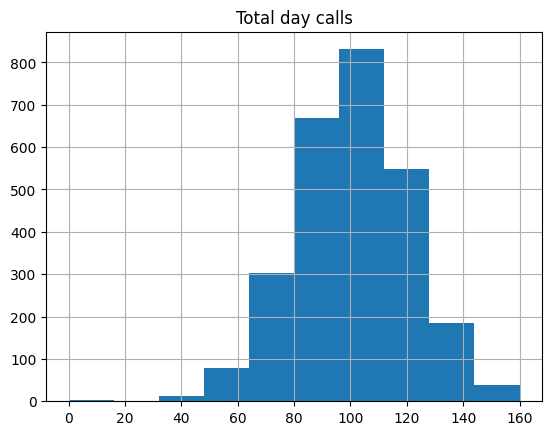

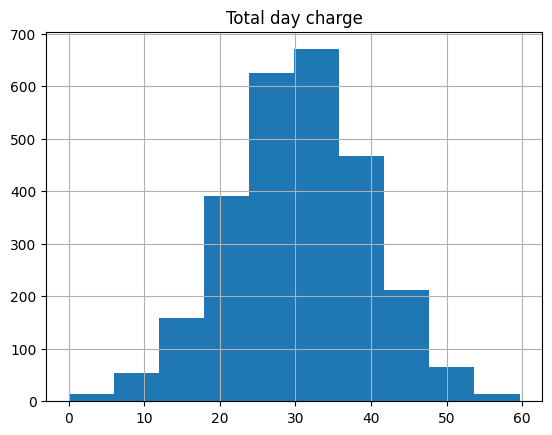

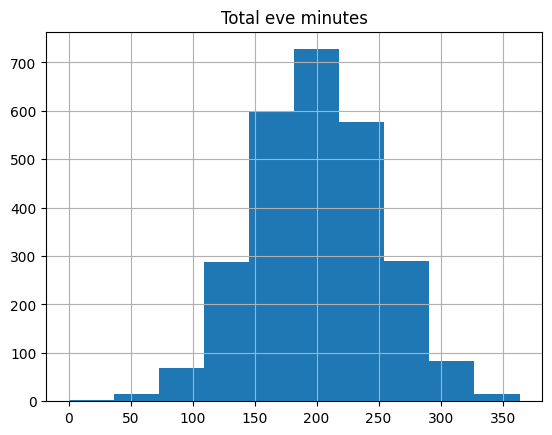

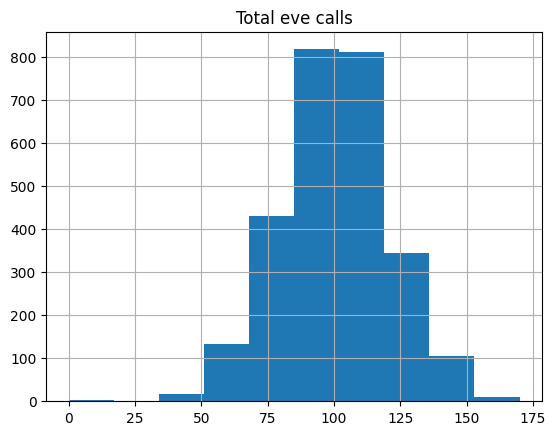

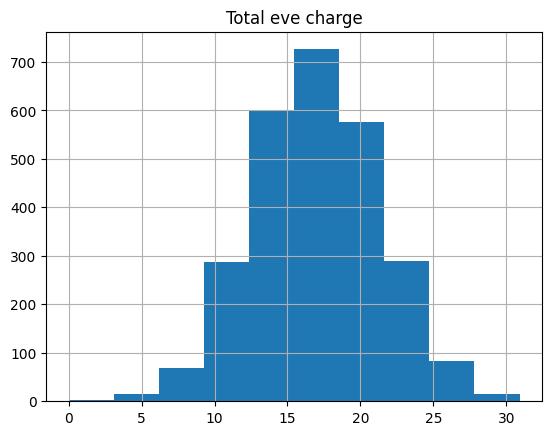

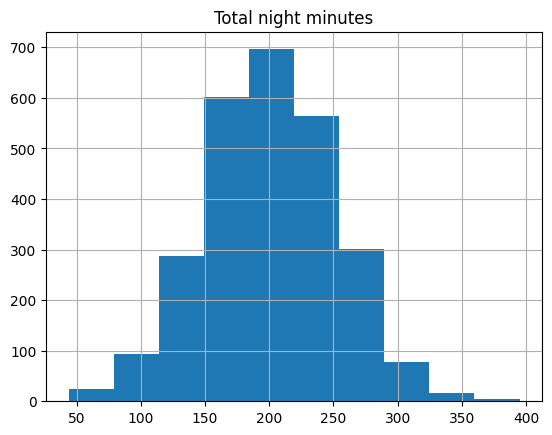

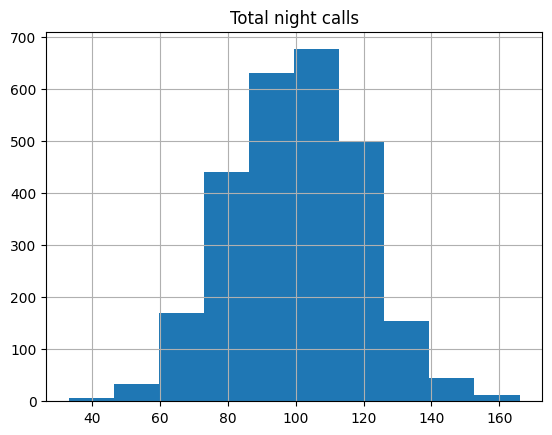

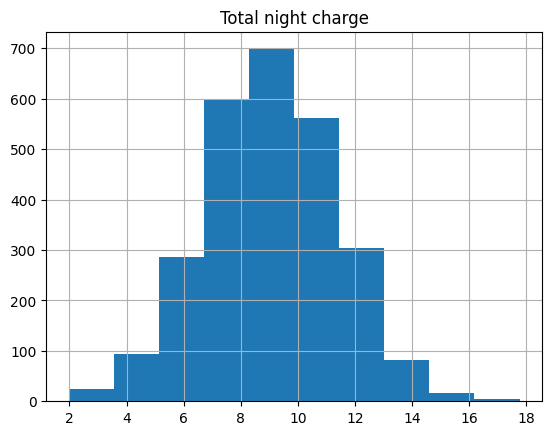

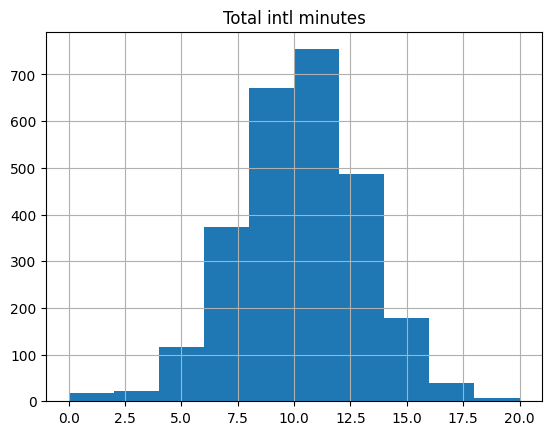

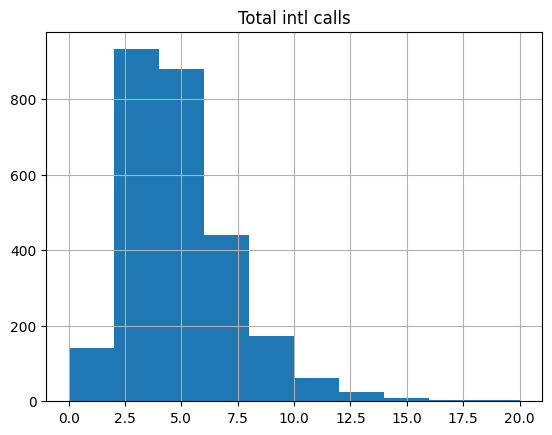

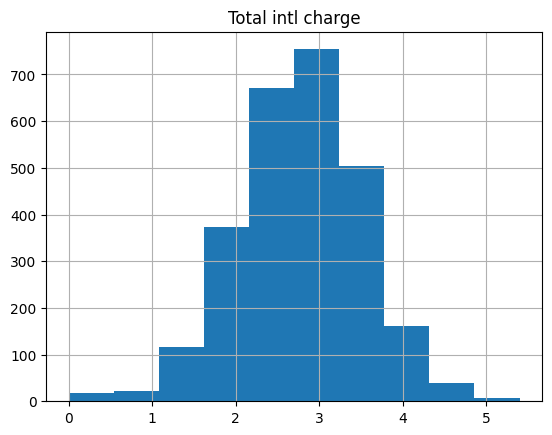

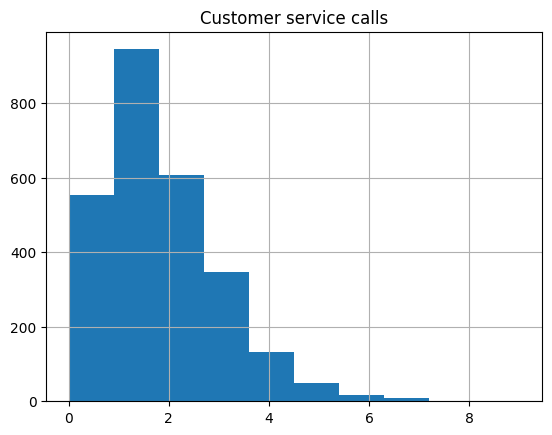

In [16]:
for col in numeric_cols:
    # Convert the column to a suitable numeric data type (e.g., float)
    df[col] = df[col].astype(float)
    df[col].hist()
    plt.title(col)
    plt.show()

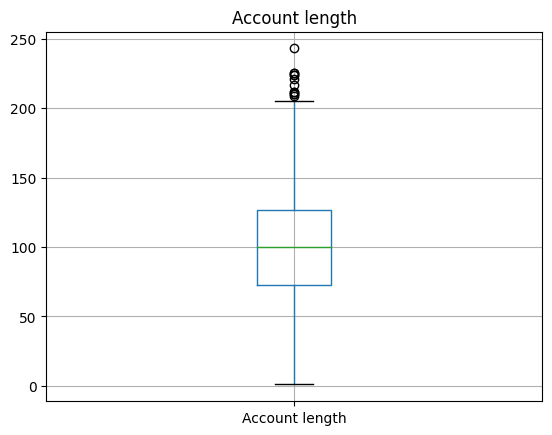

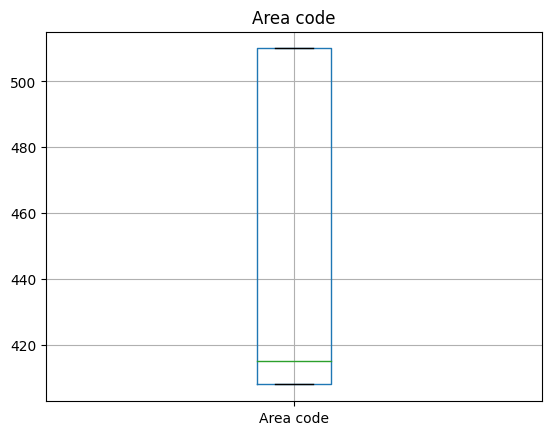

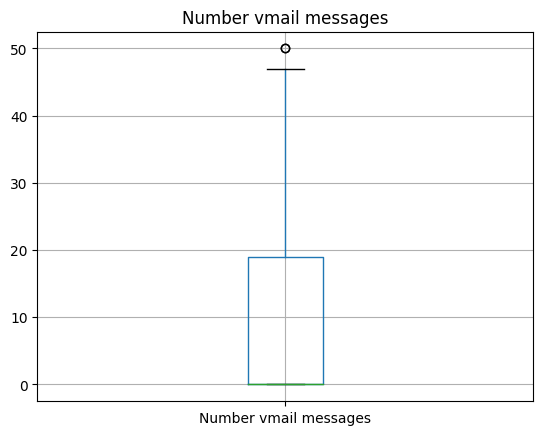

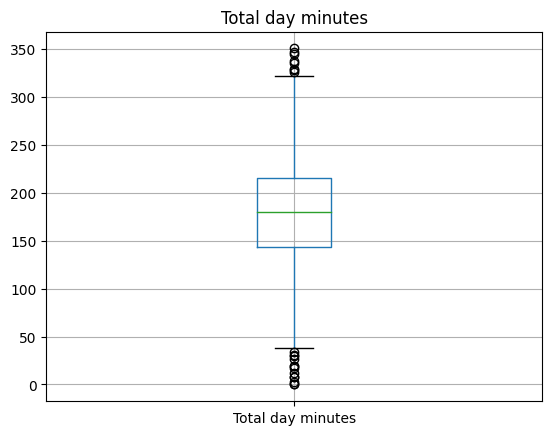

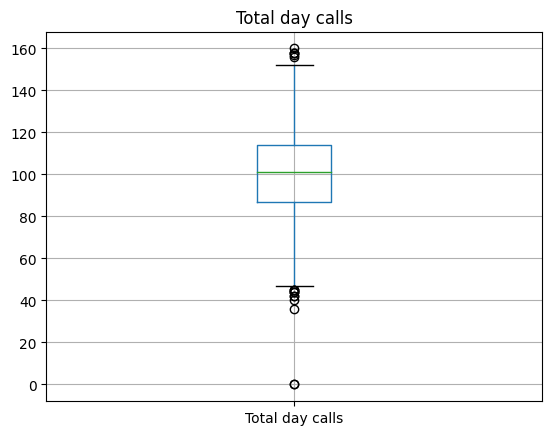

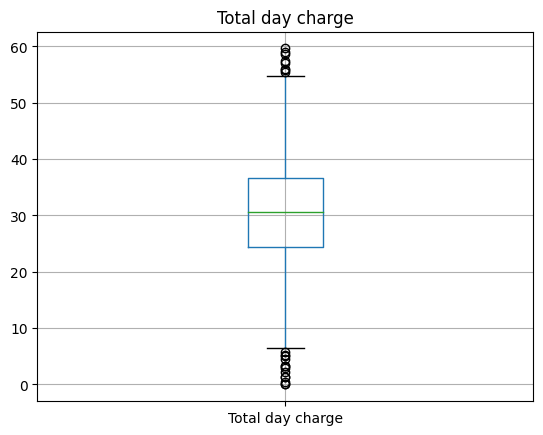

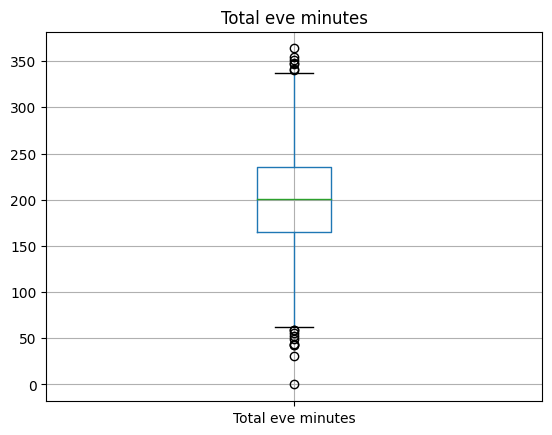

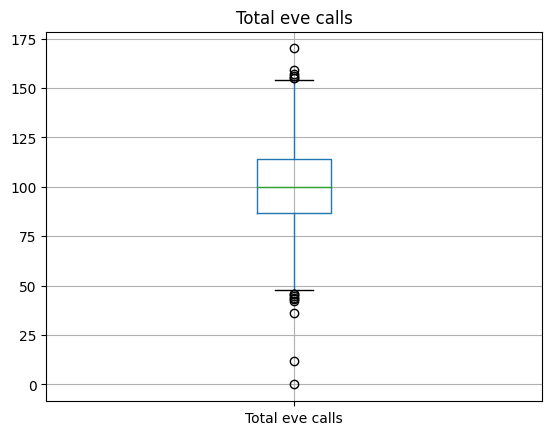

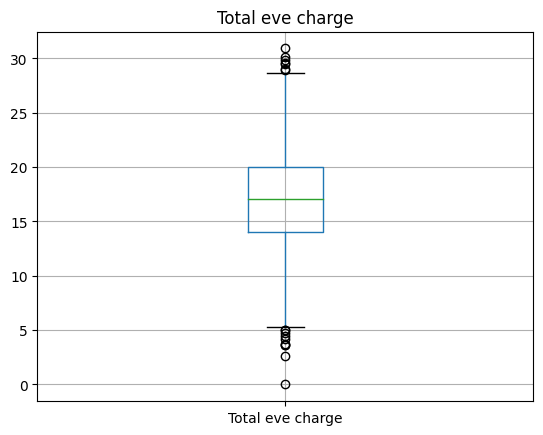

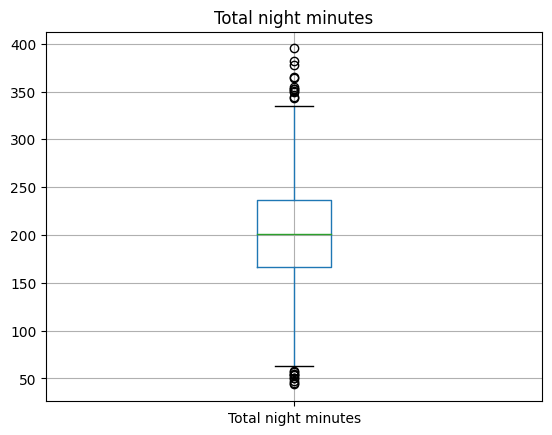

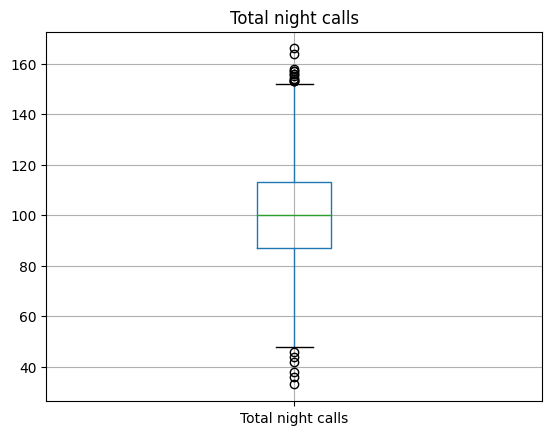

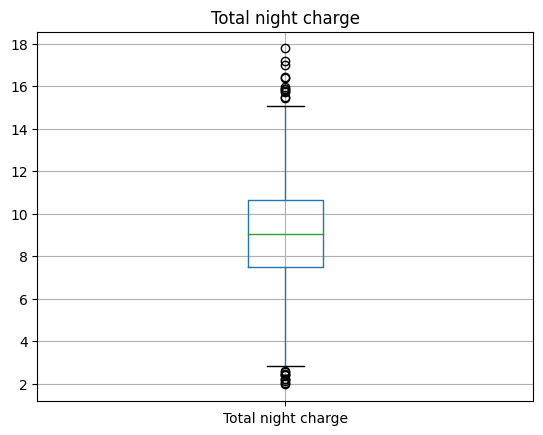

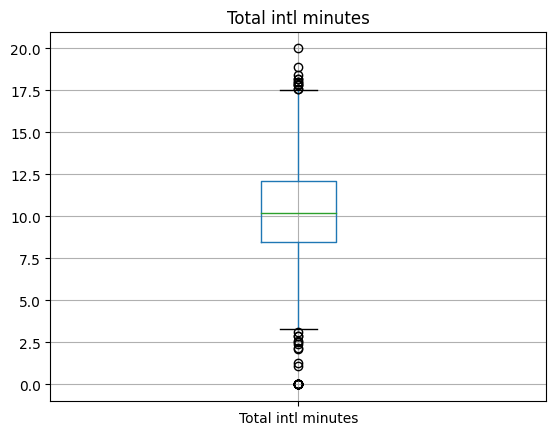

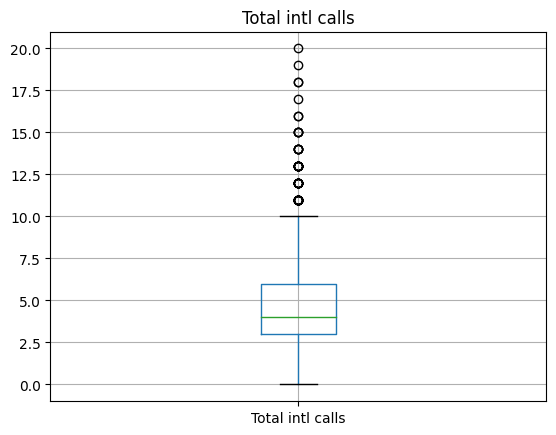

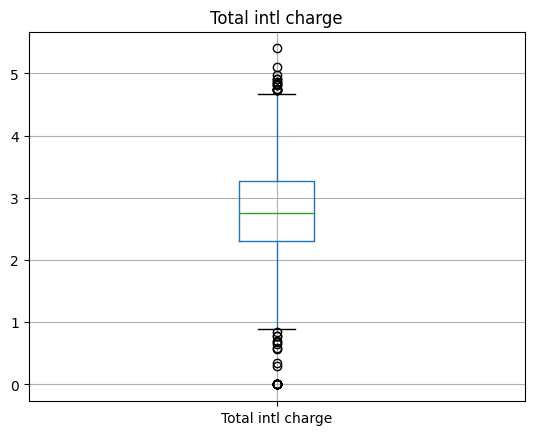

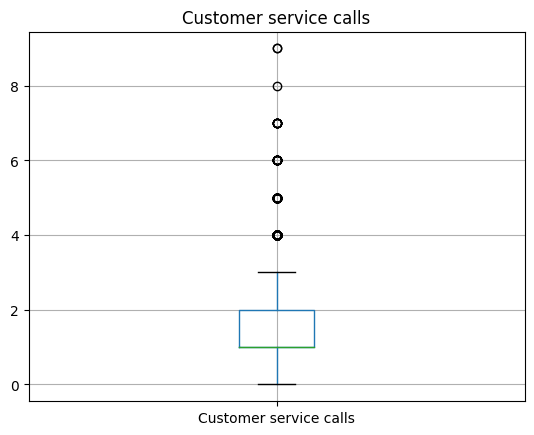

In [17]:
for col in numeric_cols:
  df.boxplot(column=[col])
  plt.title(col)
  plt.show()


Data Preprocessing

In [18]:
dataset = df.copy()

In [19]:
dataset

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128.0,415.0,No,Yes,25.0,265.1,110.0,45.07,197.4,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False
1,OH,107.0,415.0,No,Yes,26.0,161.6,123.0,27.47,195.5,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,False
2,NJ,137.0,415.0,No,No,0.0,243.4,114.0,41.38,121.2,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False
3,OH,84.0,408.0,Yes,No,0.0,299.4,71.0,50.90,61.9,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,False
4,OK,75.0,415.0,Yes,No,0.0,166.7,113.0,28.34,148.3,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,SC,79.0,415.0,No,No,0.0,134.7,98.0,22.90,189.7,68.0,16.12,221.4,128.0,9.96,11.8,5.0,3.19,2.0,False
2662,AZ,192.0,415.0,No,Yes,36.0,156.2,77.0,26.55,215.5,126.0,18.32,279.1,83.0,12.56,9.9,6.0,2.67,2.0,False
2663,WV,68.0,415.0,No,No,0.0,231.1,57.0,39.29,153.4,55.0,13.04,191.3,123.0,8.61,9.6,4.0,2.59,3.0,False
2664,RI,28.0,510.0,No,No,0.0,180.8,109.0,30.74,288.8,58.0,24.55,191.9,91.0,8.64,14.1,6.0,3.81,2.0,False


In [20]:
he = ce.HashingEncoder(cols='State')
dataset_hash = he.fit_transform(dataset)
dataset_hash

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,...,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,0,1,0,0,0,0,0,0,128.0,415.0,...,99.0,16.78,244.7,91.0,11.01,10.0,3.0,2.70,1.0,False
1,0,0,0,0,1,0,0,0,107.0,415.0,...,103.0,16.62,254.4,103.0,11.45,13.7,3.0,3.70,1.0,False
2,0,1,0,0,0,0,0,0,137.0,415.0,...,110.0,10.30,162.6,104.0,7.32,12.2,5.0,3.29,0.0,False
3,0,0,0,0,1,0,0,0,84.0,408.0,...,88.0,5.26,196.9,89.0,8.86,6.6,7.0,1.78,2.0,False
4,0,0,0,0,1,0,0,0,75.0,415.0,...,122.0,12.61,186.9,121.0,8.41,10.1,3.0,2.73,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,1,0,0,79.0,415.0,...,68.0,16.12,221.4,128.0,9.96,11.8,5.0,3.19,2.0,False
2662,0,0,0,0,0,0,1,0,192.0,415.0,...,126.0,18.32,279.1,83.0,12.56,9.9,6.0,2.67,2.0,False
2663,0,0,0,0,0,0,1,0,68.0,415.0,...,55.0,13.04,191.3,123.0,8.61,9.6,4.0,2.59,3.0,False
2664,0,0,1,0,0,0,0,0,28.0,510.0,...,58.0,24.55,191.9,91.0,8.64,14.1,6.0,3.81,2.0,False


In [21]:
dataset_hash_dummy = pd.get_dummies(dataset_hash, drop_first=True)
dataset_hash_dummy

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,...,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,International plan_Yes,Voice mail plan_Yes,Churn_True
0,0,1,0,0,0,0,0,0,128.0,415.0,...,244.7,91.0,11.01,10.0,3.0,2.70,1.0,0,1,0
1,0,0,0,0,1,0,0,0,107.0,415.0,...,254.4,103.0,11.45,13.7,3.0,3.70,1.0,0,1,0
2,0,1,0,0,0,0,0,0,137.0,415.0,...,162.6,104.0,7.32,12.2,5.0,3.29,0.0,0,0,0
3,0,0,0,0,1,0,0,0,84.0,408.0,...,196.9,89.0,8.86,6.6,7.0,1.78,2.0,1,0,0
4,0,0,0,0,1,0,0,0,75.0,415.0,...,186.9,121.0,8.41,10.1,3.0,2.73,3.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,1,0,0,79.0,415.0,...,221.4,128.0,9.96,11.8,5.0,3.19,2.0,0,0,0
2662,0,0,0,0,0,0,1,0,192.0,415.0,...,279.1,83.0,12.56,9.9,6.0,2.67,2.0,0,1,0
2663,0,0,0,0,0,0,1,0,68.0,415.0,...,191.3,123.0,8.61,9.6,4.0,2.59,3.0,0,0,0
2664,0,0,1,0,0,0,0,0,28.0,510.0,...,191.9,91.0,8.64,14.1,6.0,3.81,2.0,0,0,0


In [22]:
# View correlation
corr = dataset_hash_dummy.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-22-3ecf458147a3>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,International plan_Yes,Voice mail plan_Yes,Churn_True
col_0,1.00,-0.20,-0.12,-0.16,-0.20,-0.11,-0.20,-0.14,0.02,-0.02,0.03,0.01,0.00,0.01,0.01,0.01,0.01,0.01,-0.04,0.01,-0.02,-0.01,-0.02,0.01,0.00,0.03,-0.04
col_1,-0.20,1.00,-0.12,-0.16,-0.20,-0.11,-0.19,-0.14,0.00,-0.03,0.00,0.06,0.00,0.06,-0.02,0.01,-0.02,-0.02,0.01,-0.02,0.03,0.01,0.03,0.02,-0.00,-0.00,0.05
col_2,-0.12,-0.12,1.00,-0.10,-0.12,-0.07,-0.12,-0.09,-0.01,0.01,-0.02,-0.03,-0.01,-0.03,0.03,-0.04,0.03,-0.00,0.04,-0.00,-0.01,0.01,-0.01,-0.02,-0.02,-0.01,-0.00
col_3,-0.16,-0.16,-0.10,1.00,-0.16,-0.09,-0.16,-0.12,0.02,0.03,-0.01,-0.00,0.02,-0.00,0.03,0.02,0.03,0.01,0.00,0.01,0.00,-0.02,0.00,0.02,0.03,-0.01,-0.00
col_4,-0.20,-0.20,-0.12,-0.16,1.00,-0.11,-0.19,-0.14,0.00,0.00,0.00,0.02,-0.00,0.02,0.02,0.02,0.02,0.04,0.01,0.04,0.01,-0.02,0.01,-0.02,0.02,0.01,0.02
col_5,-0.11,-0.11,-0.07,-0.09,-0.11,1.00,-0.11,-0.08,-0.03,-0.01,-0.00,-0.04,0.01,-0.04,0.01,-0.01,0.01,-0.01,0.01,-0.01,-0.02,-0.02,-0.02,-0.01,-0.01,-0.00,0.05
col_6,-0.20,-0.19,-0.12,-0.16,-0.19,-0.11,1.00,-0.14,-0.01,-0.01,-0.00,-0.03,-0.01,-0.03,-0.08,-0.03,-0.08,-0.02,0.01,-0.02,0.01,0.03,0.01,0.01,-0.04,-0.01,-0.05
col_7,-0.14,-0.14,-0.09,-0.12,-0.14,-0.08,-0.14,1.00,-0.01,0.04,-0.01,-0.01,-0.01,-0.01,0.01,0.02,0.01,-0.03,-0.01,-0.03,-0.02,-0.00,-0.02,-0.02,0.02,-0.01,-0.01
Account length,0.02,0.00,-0.01,0.02,0.00,-0.03,-0.01,-0.01,1.00,-0.01,-0.00,0.00,0.04,0.00,-0.02,0.02,-0.02,-0.01,-0.02,-0.01,0.01,0.02,0.01,0.00,0.02,0.00,0.02
Area code,-0.02,-0.03,0.01,0.03,0.00,-0.01,-0.01,0.04,-0.01,1.00,-0.00,-0.02,-0.01,-0.02,0.00,-0.02,0.00,-0.00,0.01,-0.00,-0.01,-0.03,-0.01,0.03,0.05,0.01,0.00


In [23]:
# Remove correlation columns
dataset_hash_dummy_drop_corr = dataset_hash_dummy.drop(columns=["Voice mail plan_Yes","Total day charge","Total night charge","Total eve charge","Total intl charge"])

In [24]:
dataset_hash_dummy_drop_corr

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,...,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,International plan_Yes,Churn_True
0,0,1,0,0,0,0,0,0,128.0,415.0,...,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0,0,0
1,0,0,0,0,1,0,0,0,107.0,415.0,...,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0,0,0
2,0,1,0,0,0,0,0,0,137.0,415.0,...,114.0,121.2,110.0,162.6,104.0,12.2,5.0,0.0,0,0
3,0,0,0,0,1,0,0,0,84.0,408.0,...,71.0,61.9,88.0,196.9,89.0,6.6,7.0,2.0,1,0
4,0,0,0,0,1,0,0,0,75.0,415.0,...,113.0,148.3,122.0,186.9,121.0,10.1,3.0,3.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,1,0,0,79.0,415.0,...,98.0,189.7,68.0,221.4,128.0,11.8,5.0,2.0,0,0
2662,0,0,0,0,0,0,1,0,192.0,415.0,...,77.0,215.5,126.0,279.1,83.0,9.9,6.0,2.0,0,0
2663,0,0,0,0,0,0,1,0,68.0,415.0,...,57.0,153.4,55.0,191.3,123.0,9.6,4.0,3.0,0,0
2664,0,0,1,0,0,0,0,0,28.0,510.0,...,109.0,288.8,58.0,191.9,91.0,14.1,6.0,2.0,0,0


1. Upsampling = SMOTE, Scale = MINMAX and try with Logistic Regression

In [25]:
# SMOTE & Scale
X = dataset_hash_dummy_drop_corr.drop(["Churn_True"], axis=1)
y = dataset_hash_dummy_drop_corr['Churn_True']

In [26]:
dataset_hash_dummy_drop_corr

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,Account length,Area code,...,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes,Total intl calls,Customer service calls,International plan_Yes,Churn_True
0,0,1,0,0,0,0,0,0,128.0,415.0,...,110.0,197.4,99.0,244.7,91.0,10.0,3.0,1.0,0,0
1,0,0,0,0,1,0,0,0,107.0,415.0,...,123.0,195.5,103.0,254.4,103.0,13.7,3.0,1.0,0,0
2,0,1,0,0,0,0,0,0,137.0,415.0,...,114.0,121.2,110.0,162.6,104.0,12.2,5.0,0.0,0,0
3,0,0,0,0,1,0,0,0,84.0,408.0,...,71.0,61.9,88.0,196.9,89.0,6.6,7.0,2.0,1,0
4,0,0,0,0,1,0,0,0,75.0,415.0,...,113.0,148.3,122.0,186.9,121.0,10.1,3.0,3.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2661,0,0,0,0,0,1,0,0,79.0,415.0,...,98.0,189.7,68.0,221.4,128.0,11.8,5.0,2.0,0,0
2662,0,0,0,0,0,0,1,0,192.0,415.0,...,77.0,215.5,126.0,279.1,83.0,9.9,6.0,2.0,0,0
2663,0,0,0,0,0,0,1,0,68.0,415.0,...,57.0,153.4,55.0,191.3,123.0,9.6,4.0,3.0,0,0
2664,0,0,1,0,0,0,0,0,28.0,510.0,...,109.0,288.8,58.0,191.9,91.0,14.1,6.0,2.0,0,0


In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=42)
sm = SMOTE(k_neighbors=5)
X_train_resample, y_train_resample = sm.fit_resample(X_train,y_train)

In [28]:
scale_columns = ['Total night calls', 'Total eve calls', 'Total day calls',
       'Area code', 'Account length','Total intl calls','Customer service calls','Total eve minutes',
                 'Total night minutes','Total intl minutes']

scaler = MinMaxScaler()
scaler.fit(X_train_resample[scale_columns])
X_train_resample[scale_columns] = scaler.transform(X_train_resample[scale_columns])
X_test[scale_columns] = scaler.transform(X_test[scale_columns])

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       455
           1       0.46      0.33      0.39        79

    accuracy                           0.84       534
   macro avg       0.68      0.63      0.65       534
weighted avg       0.83      0.84      0.83       534



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 800x600 with 0 Axes>

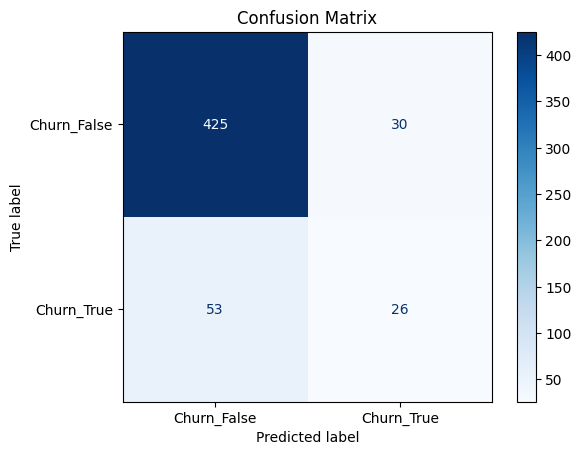

In [29]:
# Logistic Regression
model_log = LogisticRegression()
model_log.fit(X_train_resample, y_train_resample)
y_pred = model_log.predict(X_test)
print(classification_report( y_test, y_pred))
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Churn_False", "Churn_True"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

2. XGBOOST, No Upsampling, No Scale

In [30]:
X = dataset_hash_dummy_drop_corr.drop(["Churn_True"], axis=1)
y = dataset_hash_dummy_drop_corr['Churn_True']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state=42)

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       455
           1       0.94      0.76      0.84        79

    accuracy                           0.96       534
   macro avg       0.95      0.88      0.91       534
weighted avg       0.96      0.96      0.96       534



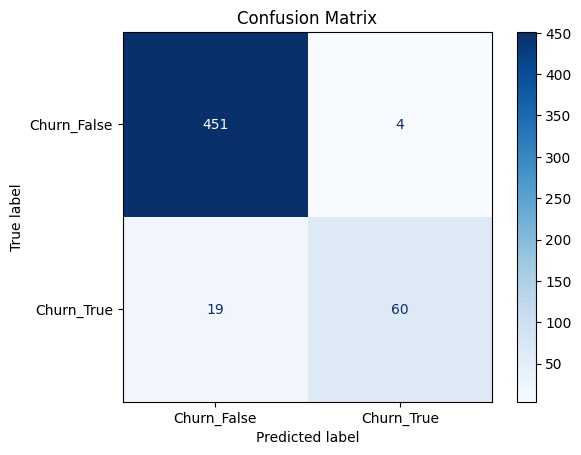

In [32]:
import xgboost as xgb
#XGB
model_xgb = xgb.XGBClassifier(random_state=42, n_estimators = 200)
model_xgb.fit(X_train, y_train)

y_pred = model_xgb.predict(X_test)
print(classification_report( y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Churn_False", "Churn_True"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

3.Random Forest

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=99)

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf = RandomForestClassifier(criterion="gini",
                            max_depth=10,
                            min_samples_split=10,
                            random_state=42)

In [36]:
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)

In [37]:
y_pred = clf.predict(X_test)

In [38]:
feature_importances = clf.feature_importances_

In [39]:
clf.feature_importances_

array([0.00428532, 0.00593278, 0.0040094 , 0.00394832, 0.00603392,
       0.00613165, 0.00296189, 0.00285896, 0.03853301, 0.00765704,
       0.03777121, 0.24687195, 0.03960975, 0.07549515, 0.03654106,
       0.05419915, 0.03331576, 0.07142849, 0.05447025, 0.16239248,
       0.10555247])

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       572
           1       0.95      0.55      0.69        95

    accuracy                           0.93       667
   macro avg       0.94      0.77      0.83       667
weighted avg       0.93      0.93      0.92       667



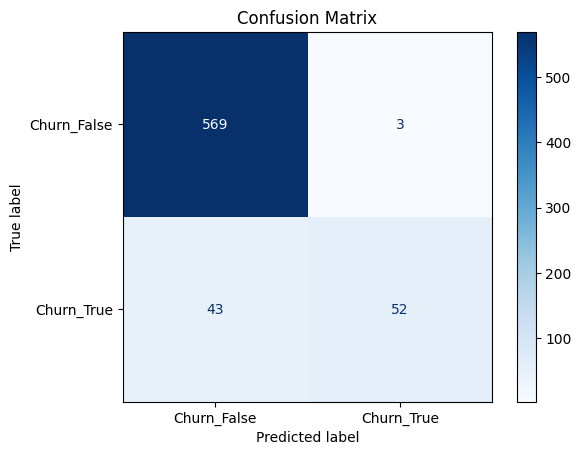

In [40]:
print(classification_report( y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

# Create and display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Churn_False", "Churn_True"])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

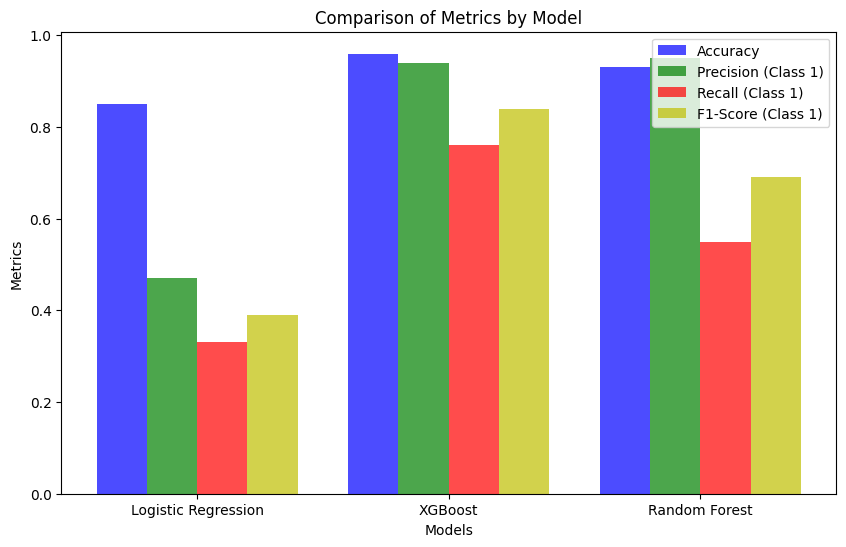

In [41]:
import matplotlib.pyplot as plt
models = ["Logistic Regression", "XGBoost", "Random Forest"]
accuracy = [0.85, 0.96, 0.93]
precision_class_1 = [0.47, 0.94, 0.95]
recall_class_1 = [0.33, 0.76, 0.55]
f1_class_1 = [0.39, 0.84, 0.69]
bar_width = 0.2
index = range(len(models))
fig, ax = plt.subplots(figsize=(10, 6))
plt.bar(index, accuracy, bar_width, label='Accuracy', color='b', alpha=0.7)
plt.bar([i + bar_width for i in index], precision_class_1, bar_width, label='Precision (Class 1)', color='g', alpha=0.7)
plt.bar([i + bar_width * 2 for i in index], recall_class_1, bar_width, label='Recall (Class 1)', color='r', alpha=0.7)
plt.bar([i + bar_width * 3 for i in index], f1_class_1, bar_width, label='F1-Score (Class 1)', color='y', alpha=0.7)
plt.xticks([i + bar_width * 1.5 for i in index], models)
plt.legend()
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.title('Comparison of Metrics by Model')
plt.show()
